In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [31]:
df = pd.read_csv('PJME_hourly.csv')

In [32]:
print(df.head())
print(df.tail())

              Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0
                   Datetime  PJME_MW
145361  2018-01-01 20:00:00  44284.0
145362  2018-01-01 21:00:00  43751.0
145363  2018-01-01 22:00:00  42402.0
145364  2018-01-01 23:00:00  40164.0
145365  2018-01-02 00:00:00  38608.0


In [33]:
df =df.set_index('Datetime')

In [34]:
df.index = pd.to_datetime(df.index)

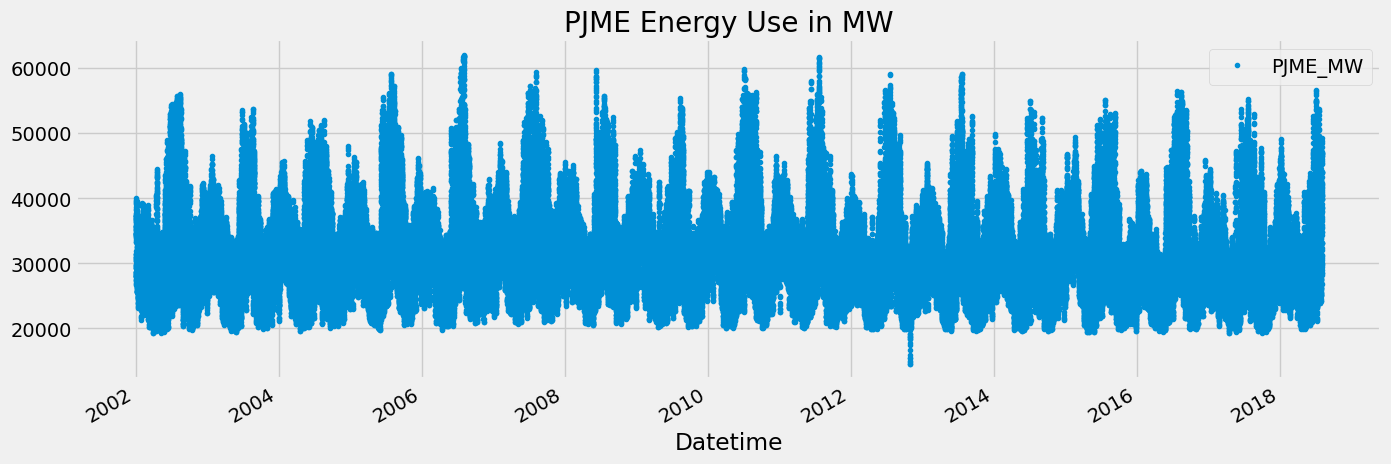

In [35]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [36]:
# checking the null counts
df.isna().sum()

PJME_MW    0
dtype: int64

# Train Test Split

In [37]:
train= df.loc[df.index < '01-01-2015']
test= df.loc[df.index >= '01-01-2015']

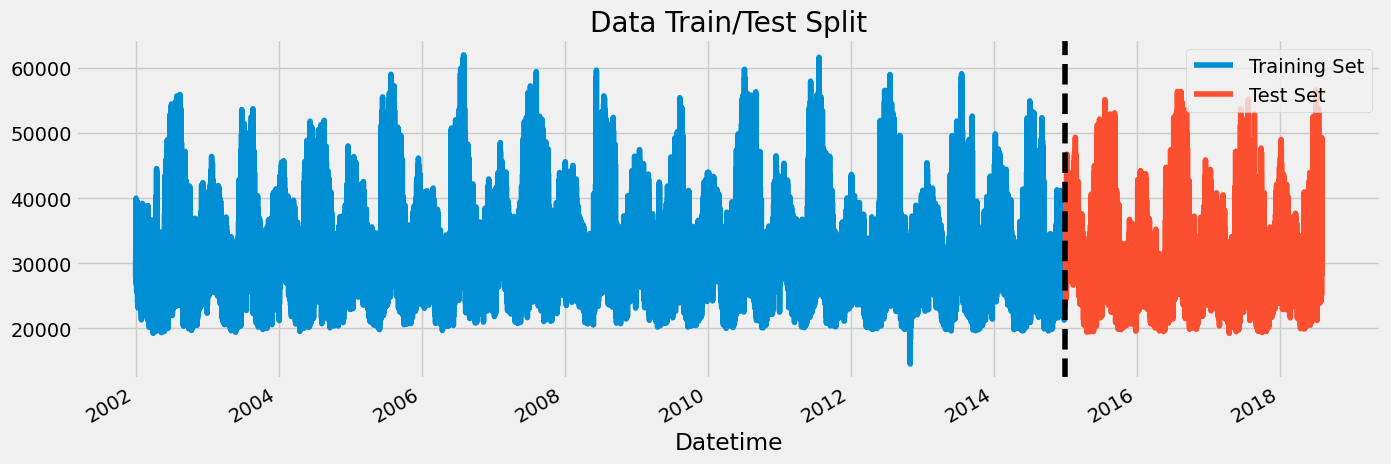

In [38]:
# plot the train and test data
fig,ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax,label='Training Set',title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

In [39]:
df = df.sort_index(axis=0)
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].head()

,PJME_MW
Datetime,
2010-01-01 01:00:00,30075.0
2010-01-01 02:00:00,28907.0
2010-01-01 03:00:00,27906.0
2010-01-01 04:00:00,27373.0
2010-01-01 05:00:00,27411.0


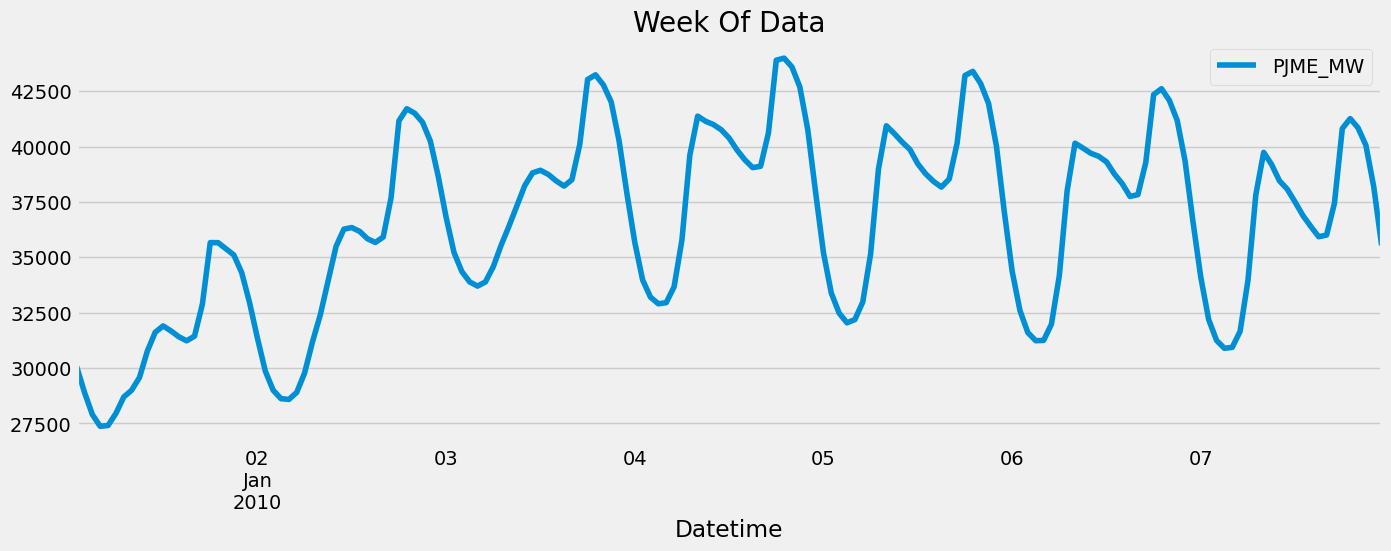

In [40]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [41]:
def feature_creation(df):
    """
    Create additional time-related features from the datetime index of the DataFrame.

    Parameters:
    - df (pandas DataFrame): DataFrame with a datetime index.

    Returns:
    pandas DataFrame: DataFrame with additional time-related features added.

    Example:
    df = pd.DataFrame(...)
    df = feature_creation(df)
    """
    df =df.copy()
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    return df


In [42]:
df= feature_creation(df)

# Visualize Feature / Target Relationship

<ipython-input-43-b5c7c64cced3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW',palette='Greens')


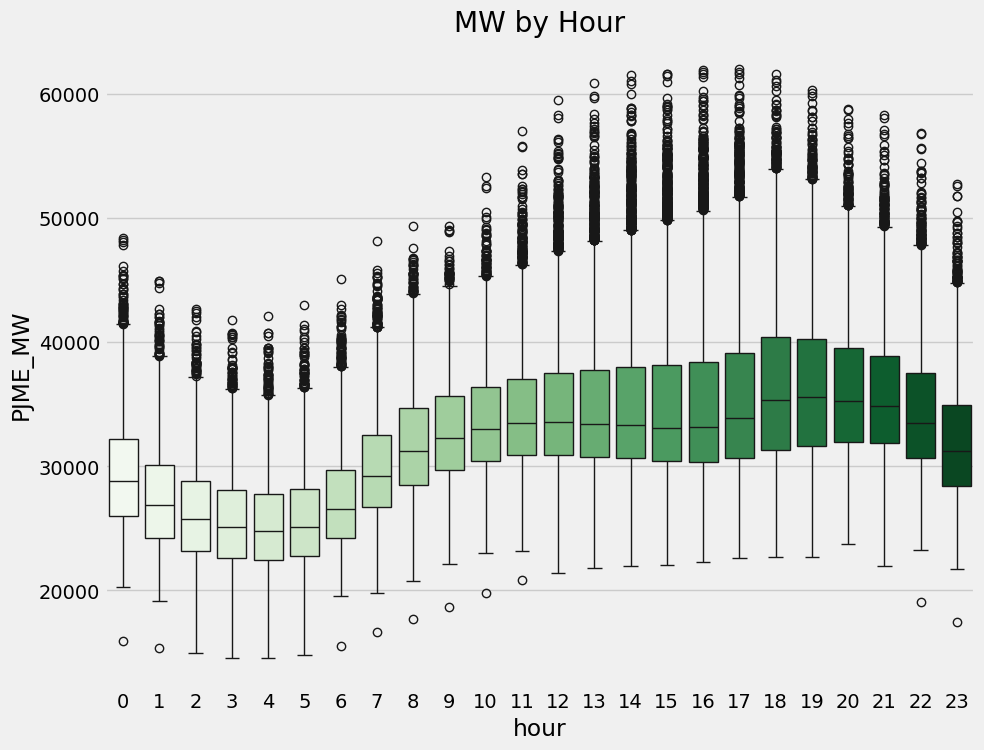

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW',palette='Greens')
ax.set_title('MW by Hour')
plt.show()

<ipython-input-44-69cf918e87c9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


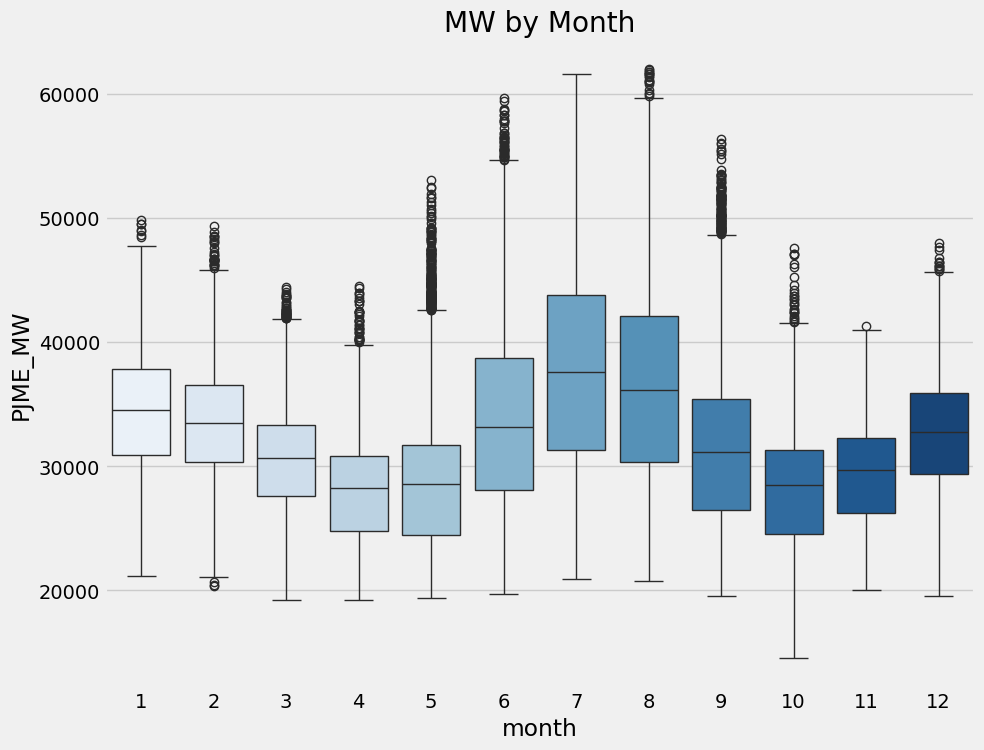

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Model Creation

In [45]:
train = feature_creation(train)
test = feature_creation(test)

In [46]:
FEATURES = ['hour', 'month', 'year', 'dayofweek', 'quarter',
       'dayofyear']
TARGET = 'PJME_MW'

In [47]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [48]:
# Import the XGBRegressor class from the xgboost library
import xgboost as xgb

# Initialize the XGBRegressor with specified parameters
reg = xgb.XGBRegressor(
    base_score=0.5,           # Base score for all predictions
    booster='gbtree',         # Booster type - 'gbtree' for gradient boosting tree
    n_estimators=1000,        # Number of boosting rounds (trees) to build
    early_stopping_rounds=50, # If the performance does not improve for 'early_stopping_rounds', training will stop
    objective='reg:linear',   # Objective function to use for regression - 'reg:linear' for linear regression
    max_depth=3,              # Maximum depth of the individual trees
    learning_rate=0.01        # Learning rate (shrinkage factor) to prevent overfitting
)

# Fit the XGBRegressor model to the training data
# The model will evaluate its performance on both training and test sets after each boosting round
# Verbose=100 means that evaluation results will be printed every 100 rounds
reg.fit(
    X_train,                  # Features of the training set
    y_train,                  # Target variable of the training set
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation sets for training and test data
    verbose=50              # Print evaluation results every 100 rounds
)


[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:25:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[50]	validation_0-rmse:20060.59753	validation_1-rmse:19152.00654
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[150]	validation_0-rmse:8242.43121	validation_1-rmse:7543.49923
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[250]	validation_0-rmse:4562.20070	validation_1-rmse:4372.53964
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[350]	validation_0-rmse:3613.62662	validation_1-rmse:3902.21057
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[450]	validation_0-rmse:3353.25804	validation_1-rmse:3831.04150
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[550]	validation_0-rmse:3242.63847	validation_1-rmse:3796.77828
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[650]	validation_0-rmse:3177.85109	validation_1-rmse:3764.15388
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[750]	validation_0-rmse:3133.02749	validation_1-rmse:3744.76096
[800]	validation_0-rmse:3114.34038	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

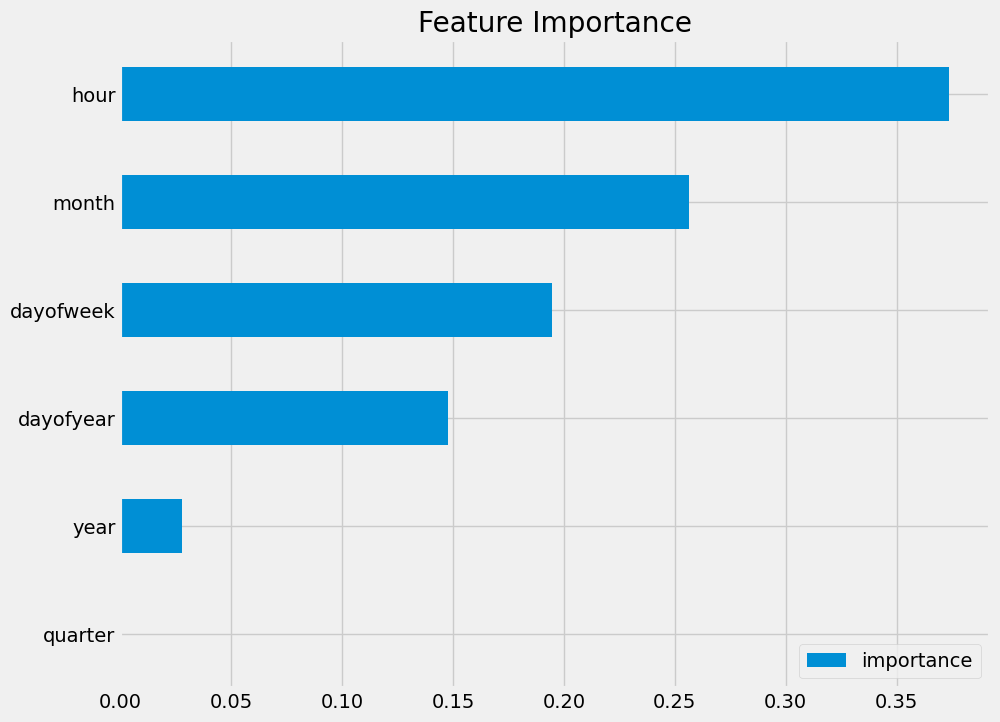

In [49]:
# Create a DataFrame for feature importances
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

# Sort the DataFrame by importance values
fi_sorted = fi.sort_values('importance')

# Plot the sorted feature importances
fig, ax = plt.subplots(figsize=(10, 8))
fi_sorted.plot(kind='barh', title='Feature Importance', ax=ax)
ax.legend(loc='lower right')  # Position the legend at the bottom right
plt.show()


In [50]:
fi

,importance
hour,0.373645
month,0.256196
year,0.027841
dayofweek,0.194571
quarter,0.000000
dayofyear,0.147746


In [51]:
test['predictions']=reg.predict(X_test)

In [52]:
true_labels= test['PJME_MW']
predictions= test['predictions']


In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import numpy as np

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(true_labels, predictions)

# Calculate R-squared (coefficient of determination)
r_squared = r2_score(true_labels, predictions)

print("R-squared (Coefficient of Determination):", round(r_squared,2))
print("Mean Squared Error (MSE):", round(mse,2))
print("Root Mean Squared Error (RMSE):", round(rmse,2))
print("Mean Absolute Percentage Error (MAPE):", round(mape,2))


R-squared (Coefficient of Determination): 0.67
Mean Squared Error (MSE): 13889027.66
Root Mean Squared Error (RMSE): 3726.8
Mean Absolute Percentage Error (MAPE): 9.16


In [54]:
df = df.merge(test[['predictions']], how='left', left_index=True, right_index=True)


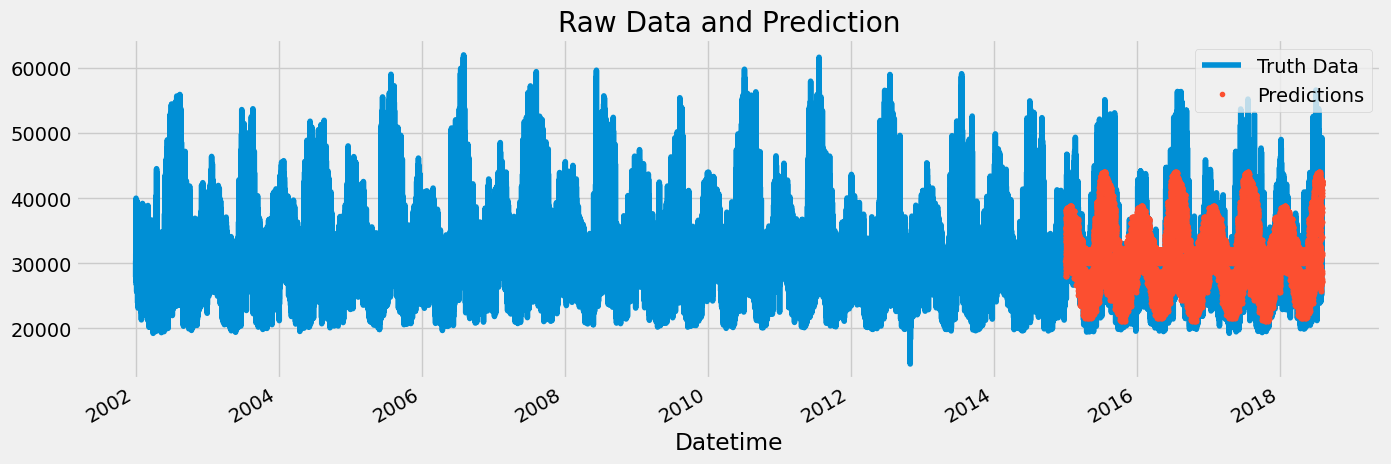

In [55]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()